# Fooled colored MNIST (Try to put more focus on colors instead of the shape of the digits)
The idea is to create a model, which should be able to asses, if the digit in the image is a low or a high number. The image dataset of colored digits is divided into three parts namely the train, validation and test datasets. In the train and validatin datasets, the low numbers are colored in red and the high numbers are colored in green. In the test dataset, the colors are random. If the model is able to recognize the value of the digits from it's shape, the performance should be nearly equal as the performance on the train and validation datasets. The hypothesis is, that the model will learn to separate low from high digits based on their color and therefore will fail on the test dataset.

## Setup environment

In [1]:
import torch

torch.cuda.empty_cache()

In [3]:
# basic modules
import numpy as np
import matplotlib.pyplot as plt
import sys

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision import models as torch_models
from torchvision import __version__ as torchvision_version

%load_ext autoreload
%autoreload 2

print("Torch version:", torch.__version__)

Torch version: 1.13.0a0+d0d6b1f


In [5]:
# include plots in notebook
%matplotlib inline

In [7]:
# check environment
print("Python version: ", sys.version)
print("Pytorch version: ", torch.__version__)
print("Torchvision version: ", torchvision_version)

!nvidia-smi

Python version:  3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
Pytorch version:  1.13.0a0+d0d6b1f
Torchvision version:  0.14.0a0
Sun Jan 15 05:29:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:34:00.0 Off |                    0 |
| N/A   37C    P0    69W / 350W |  32200MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+--

## Prepare dataset

In [9]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *
from utils.mnist_general import *

# dataset parameters
DATASET_BATCH_SIZE = 128
DATASET_SHUFFLE = True

In [11]:
import clip

model, preprocess = clip.load("RN50")

MNIST dataset already exists


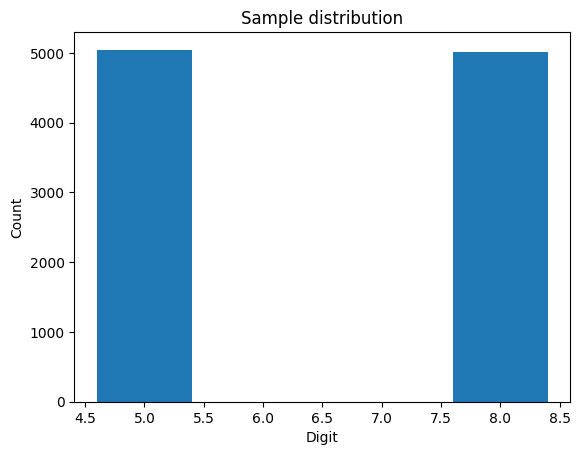

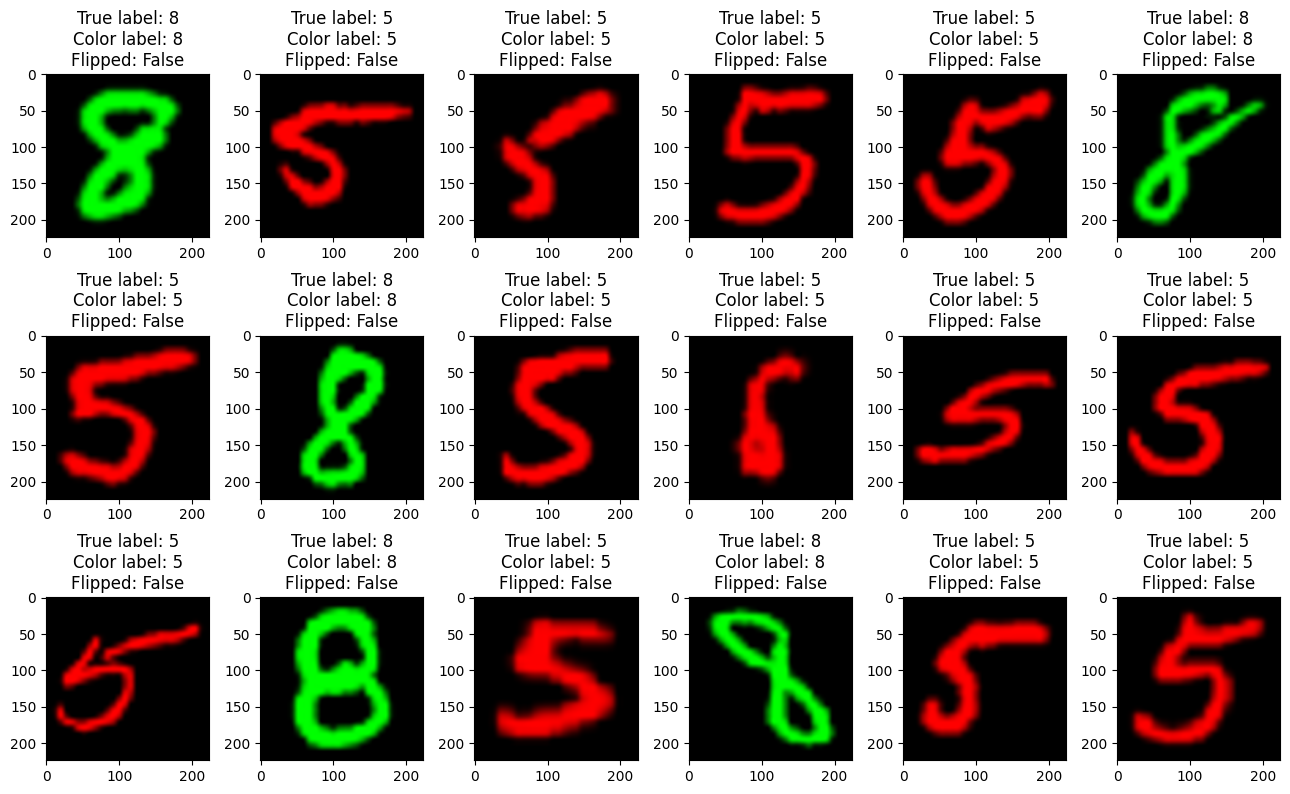

In [13]:
# create and select training dataset
# original 10 class problem
# DatasetMNIST(root='./data',
#                             env='train',
#                             color=True,
#                             opt_postfix="10classes",
#                             first_color_max_nr=4,
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
# DatasetMNIST(root='./data',
#                             env='train',
#                             color=False,
#                             opt_postfix="10classes",
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
train_set = DatasetMNIST(root='./data',
                            env='train',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

digit_distribution(train_set)
plot_digits(train_set, preprocess)

MNIST dataset already exists


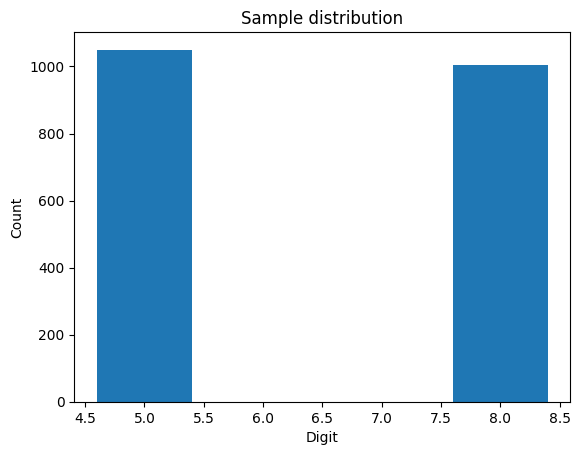

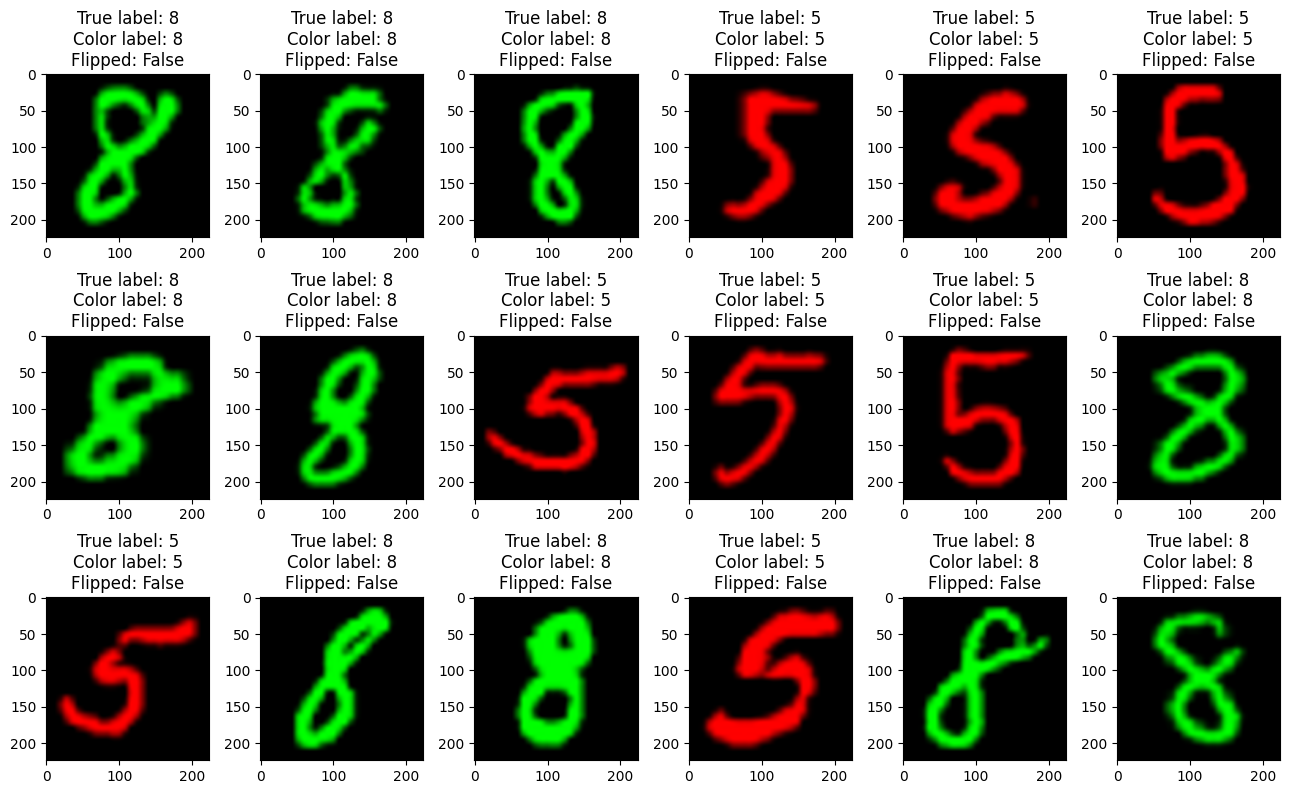

In [15]:
# create and select validation dataset
# original 10 class problem
# DatasetMNIST(root='./data',
#                             env='val',
#                             color=True,
#                             opt_postfix="10classes",
#                             first_color_max_nr=4,
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
# DatasetMNIST(root='./data',
#                             env='val',
#                             color=False,
#                             opt_postfix="10classes",
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
val_set = DatasetMNIST(root='./data',
                            env='val',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

digit_distribution(val_set)
plot_digits(val_set, preprocess)

MNIST dataset already exists


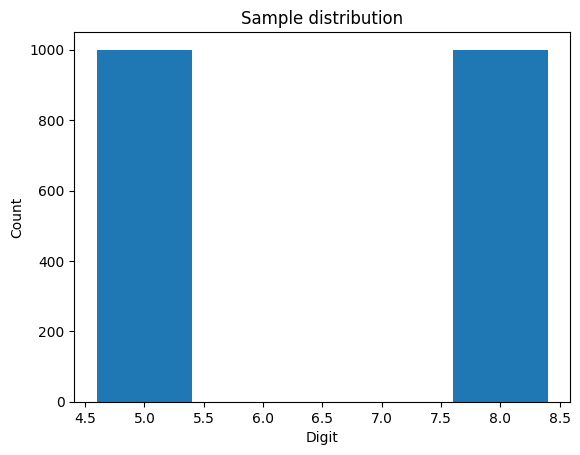

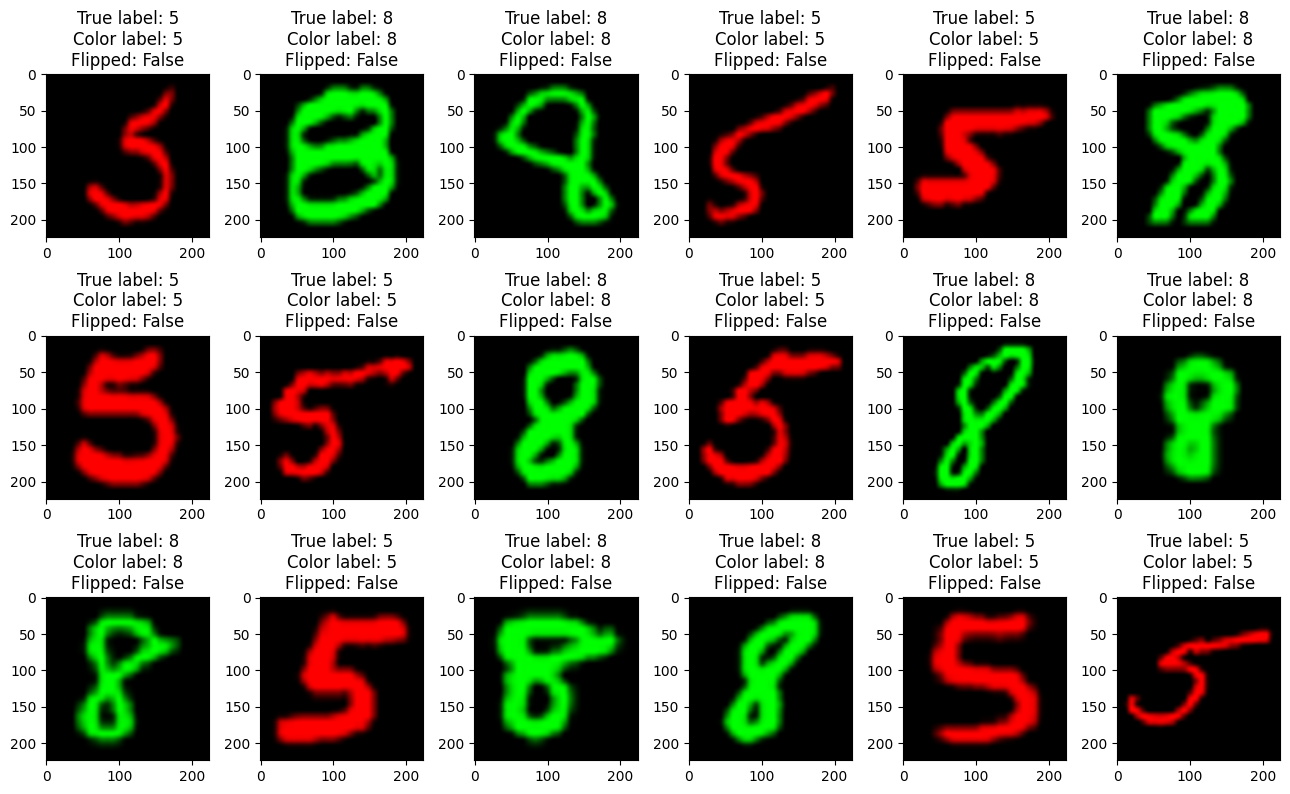

In [17]:
# create and select test dataset
# original 10 class problem
# DatasetMNIST(root='./data',
#                             env='test',
#                             color=True,
#                             opt_postfix="10classes",
#                             first_color_max_nr=4,
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
# DatasetMNIST(root='./data',
#                             env='test',
#                             color=False,
#                             opt_postfix="10classes",
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
test_set = DatasetMNIST(root='./data',
                            env='test',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

digit_distribution(test_set)
plot_digits(test_set, preprocess)

MNIST dataset already exists


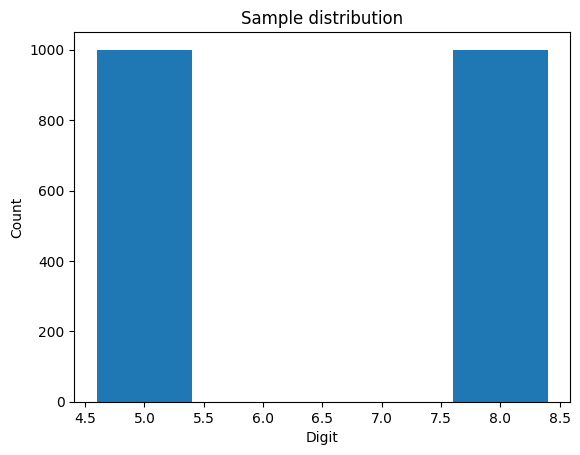

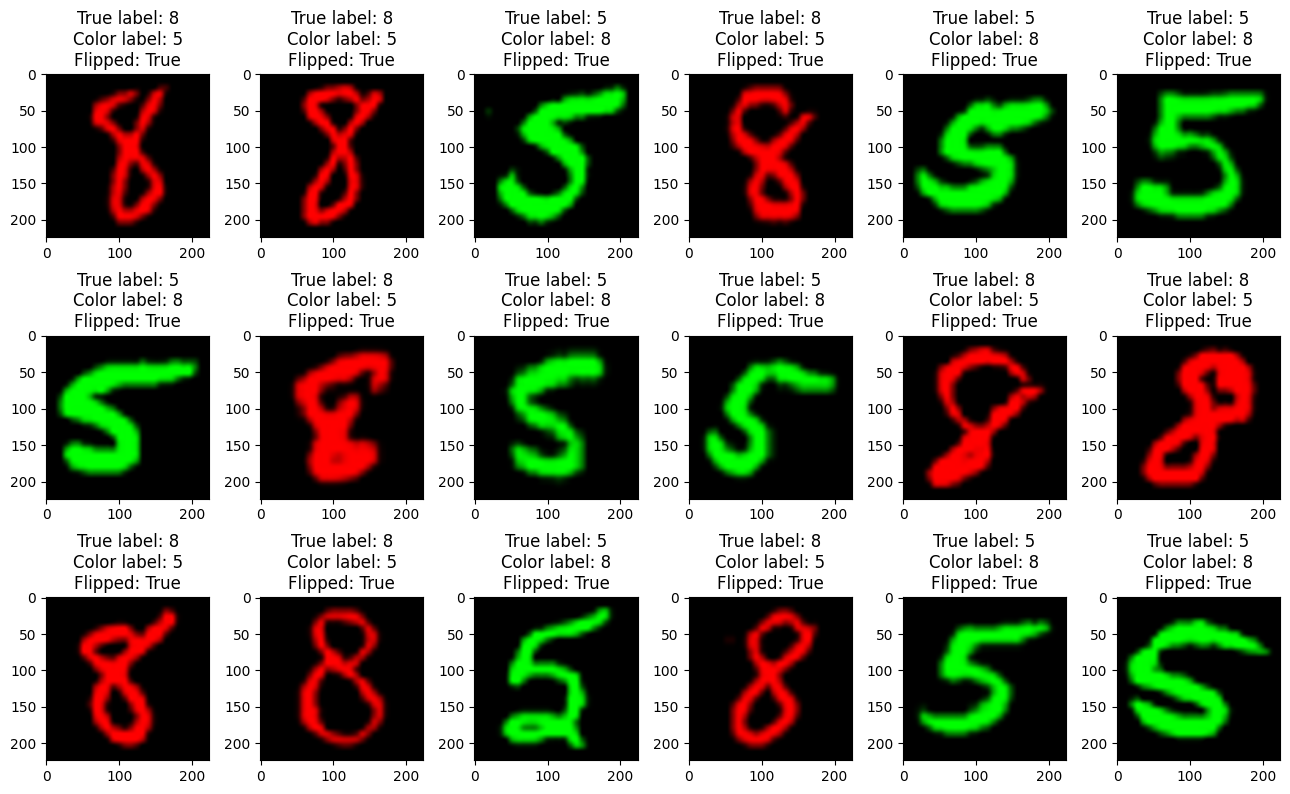

In [19]:
# create and select test_fool dataset
# original 10 class problem
# DatasetMNIST(root='./data',
#                             env='test_fool',
#                             color=True,
#                             opt_postfix="10classes",
#                             first_color_max_nr=4,
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
# DatasetMNIST(root='./data',
#                             env='test_fool',
#                             color=False,
#                             opt_postfix="10classes",
#                             preprocess=preprocess,
#                             transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
test_set_fool = DatasetMNIST(root='./data',
                            env='test_fool',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

test_fool_loader = torch.utils.data.DataLoader(dataset=test_set_fool,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE)

digit_distribution(test_set_fool)
plot_digits(test_set_fool, preprocess)

## Basic checks for correct labels

In [21]:
# check, if all test labels are correct (all high_low labels are equal to the color labels -> No messages expected)
for idx, i in enumerate(test_loader):
    if not ((i[2] == i[3]).all().item()):
        print("Error! in batch ", idx)

Error! in batch  0
Error! in batch  1
Error! in batch  2
Error! in batch  3
Error! in batch  4
Error! in batch  5
Error! in batch  6
Error! in batch  7
Error! in batch  8
Error! in batch  9
Error! in batch  10
Error! in batch  11
Error! in batch  12
Error! in batch  13
Error! in batch  14
Error! in batch  15


In [23]:
# check, if all test_fool labels are correct (all high_low labels are opposite to the color labels -> No messages expected)
for idx, i in enumerate(test_fool_loader):
    if not ((i[2] != i[3]).all().item()):
        print("Error! in batch ", idx)

Error! in batch  0
Error! in batch  1
Error! in batch  2
Error! in batch  3
Error! in batch  4
Error! in batch  5
Error! in batch  6
Error! in batch  7
Error! in batch  8
Error! in batch  9
Error! in batch  10
Error! in batch  11
Error! in batch  12
Error! in batch  13
Error! in batch  14
Error! in batch  15


In [25]:
import itertools

# some checks with explanations
if not DATASET_SHUFFLE:
    # only make sense, if datasets are not shuffled
    for i, (data1, data2) in enumerate(zip(itertools.cycle(test_loader), test_fool_loader)):
        print(f"Same image data: {(data1[0] == data2[0]).all().item()}, because the same digit is either on red or green color channel!")
        print(f"Same ground truth label: {(data1[1] == data2[1]).all().item()}, because it's the same digit, independent from its representation")
        print(f"Same low-high label: {(data1[2] == data2[2]).all().item()}, because it's the same digit, independent from its representation")
        print(f"Same color label: {(data1[3] == data2[3]).all().item()}, because the test and test-fool sets have opposite colors")
        break

    # index within batch
    idx = 42
    
    # show same image of same digit from both datasets
    normalizer = preprocess.transforms.copy().pop()
    img1 = torch.stack((data1[0][idx][0]*torch.Tensor(normalizer.std)[0] + torch.Tensor(normalizer.mean)[0],
                        data1[0][idx][1]*torch.Tensor(normalizer.std)[1] + torch.Tensor(normalizer.mean)[1],
                        data1[0][idx][2]*torch.Tensor(normalizer.std)[2] + torch.Tensor(normalizer.mean)[2]))

    img2 = torch.stack((data2[0][idx][0]*torch.Tensor(normalizer.std)[0] + torch.Tensor(normalizer.mean)[0],
                        data2[0][idx][1]*torch.Tensor(normalizer.std)[1] + torch.Tensor(normalizer.mean)[1],
                        data2[0][idx][2]*torch.Tensor(normalizer.std)[2] + torch.Tensor(normalizer.mean)[2]))

    plt.imshow(np.transpose(img1.cpu().numpy(), (1,2,0)))
    plt.show()

    plt.imshow(np.transpose(img2.cpu().numpy(), (1,2,0)))
    plt.show()

    del normalizer
    del img1
    del img2

## Setup GPU (For number crunching)

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
from pynvml import *

nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

## Train network

In [ ]:
from sklearn.model_selection import KFold
import copy

def train_model(num_epochs=3, learning_rate=.00001):
    """
    Training procedure and performance measurement of the model.
    """
    history = {'train_w_backprop'   :   {'fold0'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold1'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold2'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold3'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold4'  : {'loss' : [],
                                                    'acc' : []}},
                
            'train'             :   {'fold0'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold1'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold2'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold3'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold4'  : {'loss' : [],
                                                    'acc' : []}},
                
            'validation'        :   {'fold0'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold1'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold2'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold3'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold4'  : {'loss' : [],
                                                    'acc' : []}},
                
            'test'              :   {'fold0'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold1'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold2'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold3'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold4'  : {'loss' : [],
                                                    'acc' : []}},
                
            'test_fool'         :   {'fold0'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold1'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold2'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold3'  : {'loss' : [],
                                                    'acc' : []},
                                        'fold4'  : {'loss' : [],
                                                    'acc' : []}}
        }
    
    # setup model
    # https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights
    # model = torch_models.resnet50(pretrained=True)
    model = torch_models.resnet50(weights='IMAGENET1K_V2')
    for param in model.parameters():
        param.requires_grad = False
    # replace the last fully-connected layer
    # parameters of newly constructed modules have required_grad=True by default
    model.fc = nn.Linear(2048, 2)
    model = model.to(device)
    model.train()
    
    # create a model for each of the kfolds with same initial conditions
    # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
    KFOLDS = 5
    kfold = KFold(n_splits=KFOLDS, shuffle=True)
    models = []
    for i in range(KFOLDS):
        models.append(copy.deepcopy(model))
    del model
    
    # F.sigmoid (Map values between 0 and 1) + F.binary_cross_entropy
    # https://zhang-yang.medium.com/how-is-pytorchs-binary-cross-entropy-with-logits-function-related-to-sigmoid-and-d3bd8fb080e7
    # https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
    #criterion = F.binary_cross_entropy_with_logits #(input, target)
    criterion = nn.CrossEntropyLoss()
    
    for fold, (train_ids, test_ids) in enumerate(kfold.split(train_set)):
        
        # Sample elements randomly from a given list of ids, no replacement.
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
            
        # Define data loaders for training and testing data in this fold
        trainloader = torch.utils.data.DataLoader(
                        train_set, 
                        batch_size=1024, sampler=train_subsampler)
        valloader   = torch.utils.data.DataLoader(
                        train_set,
                        batch_size=1024, sampler=val_subsampler)
        
        # setup optimizer
        optimizer = optim.Adam(models[fold].fc.parameters(), lr=learning_rate)
        
        # train model for number of epochs
        for epoch in range(num_epochs):
            
            for phase in history.keys():
                
                # phase configuration
                if phase == 'train_w_backprop':
                    models[fold].train()
                    datasource = trainloader
                elif phase == "train":
                    models[fold].eval()
                    datasource = trainloader
                elif phase == "validation":
                    models[fold].eval()
                    datasource = valloader
                elif phase == "test":
                    models[fold].eval()
                    datasource = test_loader
                elif phase == "test_fool":
                    models[fold].eval()
                    datasource = test_fool_loader
                else:
                    raise NotImplementedError("Sorry, unknown phase!")

                # training to learn weights
                epoch_loss = 0.0
                running_corrects = 0
                label_counter = 0
                for inputs, _, low_high_lables, _ in datasource:
                    
                    # inference
                    inputs = inputs.to(device)
                    low_high_lables = low_high_lables.to(device)
                    if phase == 'train_w_backprop':
                        logits = models[fold](inputs)
                    else:
                        with torch.no_grad():
                            logits = models[fold](inputs)
                    
                    # sanity check: ensure only one unique max for next step
                    unique_max = (logits == torch.max(logits)).nonzero().shape == torch.Size([1, 2])
                    if (not unique_max):
                        print("Error: not unique max! Take first!")
                    
                    # prediction
                    preds = logits.argmax(dim=1)
                    running_corrects += torch.sum(preds == low_high_lables.data)
                    label_counter += low_high_lables.size()[0]
                    
                    # loss
                    batch_loss = criterion(logits, low_high_lables)
                    epoch_loss += batch_loss.item()

                    # training
                    if phase == 'train_w_backprop':
                        optimizer.zero_grad()   # Sets the gradients of all optimized torch.Tensor to zero.
                        batch_loss.backward()   # compute gradients
                        optimizer.step()        # Performs a single optimization step (parameter update)
                        
                epoch_acc = 100 * running_corrects.double() / label_counter
                print('Model on fold {}: epoch {} loss: {:.4f}, acc: {:.4f} ({})'.format(fold,
                                                                                        epoch,
                                                                                        epoch_loss,
                                                                                        epoch_acc,
                                                                                        phase))
                
                history[phase]["fold"+str(fold)]['loss'].append(epoch_loss)
                history[phase]["fold"+str(fold)]['acc'].append(epoch_acc.cpu().item())

    # select best model based on validation score
    best_model_idx = 0
    highest_model_acc = 0
    for i in range(KFOLDS):
        if (history['validation']["fold"+str(i)]['acc'][-1] > highest_model_acc):
            highest_model_acc = history['validation']["fold"+str(i)]['acc'][-1]
            best_model_idx = i
            
    best_model = copy.deepcopy(models[best_model_idx])
    
    # cleanup GPU
    del inputs
    del low_high_lables
    del models
    torch.cuda.empty_cache()
    
    return best_model, history

In [ ]:
import pickle

# 1 epoch takes 5min
model, model_history = train_model(num_epochs=60, learning_rate=.001)

# file config
MODEL_BACKUP = "standalone_resnet50_biased"
model_path, history_path = get_model_paths(MODEL_BACKUP)

# save data
if True:
    pickle.dump(model, open(model_path, 'wb'))
    pickle.dump(model_history, open(history_path, 'wb'))

# cleanup
del model
del model_history
torch.cuda.empty_cache()

In [45]:
# load data
if True:
    model_path, history_path = get_model_paths(MODEL_BACKUP)
    model = pickle.load(open(model_path, 'rb'))
    model_history = pickle.load(open(history_path, 'rb'))

Load model from /home/patrick.koller/masterthesis/data/results/standalone_resnet50_biased.mdl
Load history from /home/patrick.koller/masterthesis/data/results/standalone_resnet50_biased_history.hist


## Assess performance

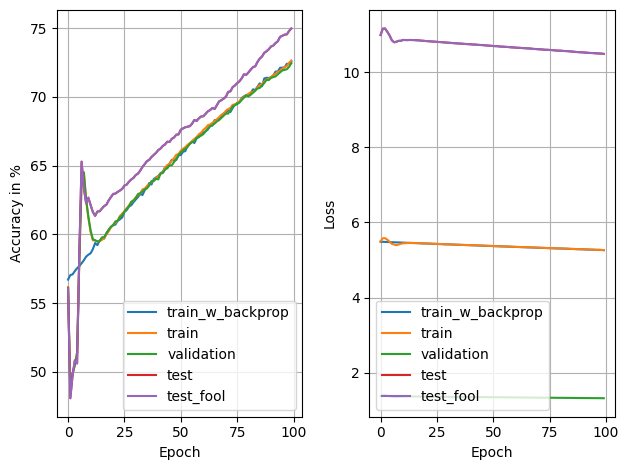

In [46]:
plot_history(model_history, show_points=False)

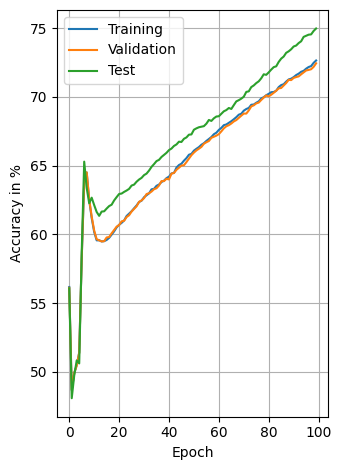

In [47]:
# plot for documentation with less distraction
plot_history(model_history, show_plots=['acc'], show_points=False,
             show_curves=['train', 'validation', 'test'],
             alternative_labels=['Training', 'Validation','Test'])

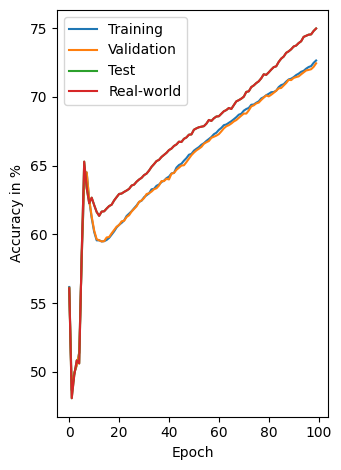

In [48]:
# plot for documentation with less distraction
plot_history(model_history, show_plots=['acc'], show_points=False,
             show_curves=['train', 'validation', 'test', 'test_fool'],
             alternative_labels=['Training', 'Validation', 'Test', 'Real-world'])

Why is the validation accuracy higher than the training accuracy?  

Answer, if a dropout layer is in use: (There is no dropout layer in resnet50)  
This is a typical behaviour when using dropout, since the behaviour during training and testing are different. When training, a percentage of the features are set to zero (50%, if dropout(0.5)). When testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies.

Answer for this situation:  
Most probably, the training (50000 samples) and the test (10000 samples) datasets are not 100% i.i.d. from the same distribution and there are some less complicated samples in the smaller test dataset. This usually is the case, if the test loss is smaller than the training loss. This hypothesis needs to be proven! This can be confirmed in a simple and easy way by switching the training and the test dataset and validate on the training dataset. In this case the training loss curve (obtained with the test dataset) is lower than the validation loss curve (obtained with the training dataset)! Of course, this is not a 100% perfect proof, but a simple and easy indicator to support this hypothesis. If this should be a problem, more analysis of the data needs to be done. No crossvalidation needed, since the results are very similar over different runs (Despite shuffling the datasets) and there is no large variance in the learning curves.

Other great thoughts by Aurélien Geron: Sometimes validation loss < training loss. Ever wondered why?  
https://twitter.com/aureliengeron/status/1110839223878184960

Batch accuracy: 97.65625%


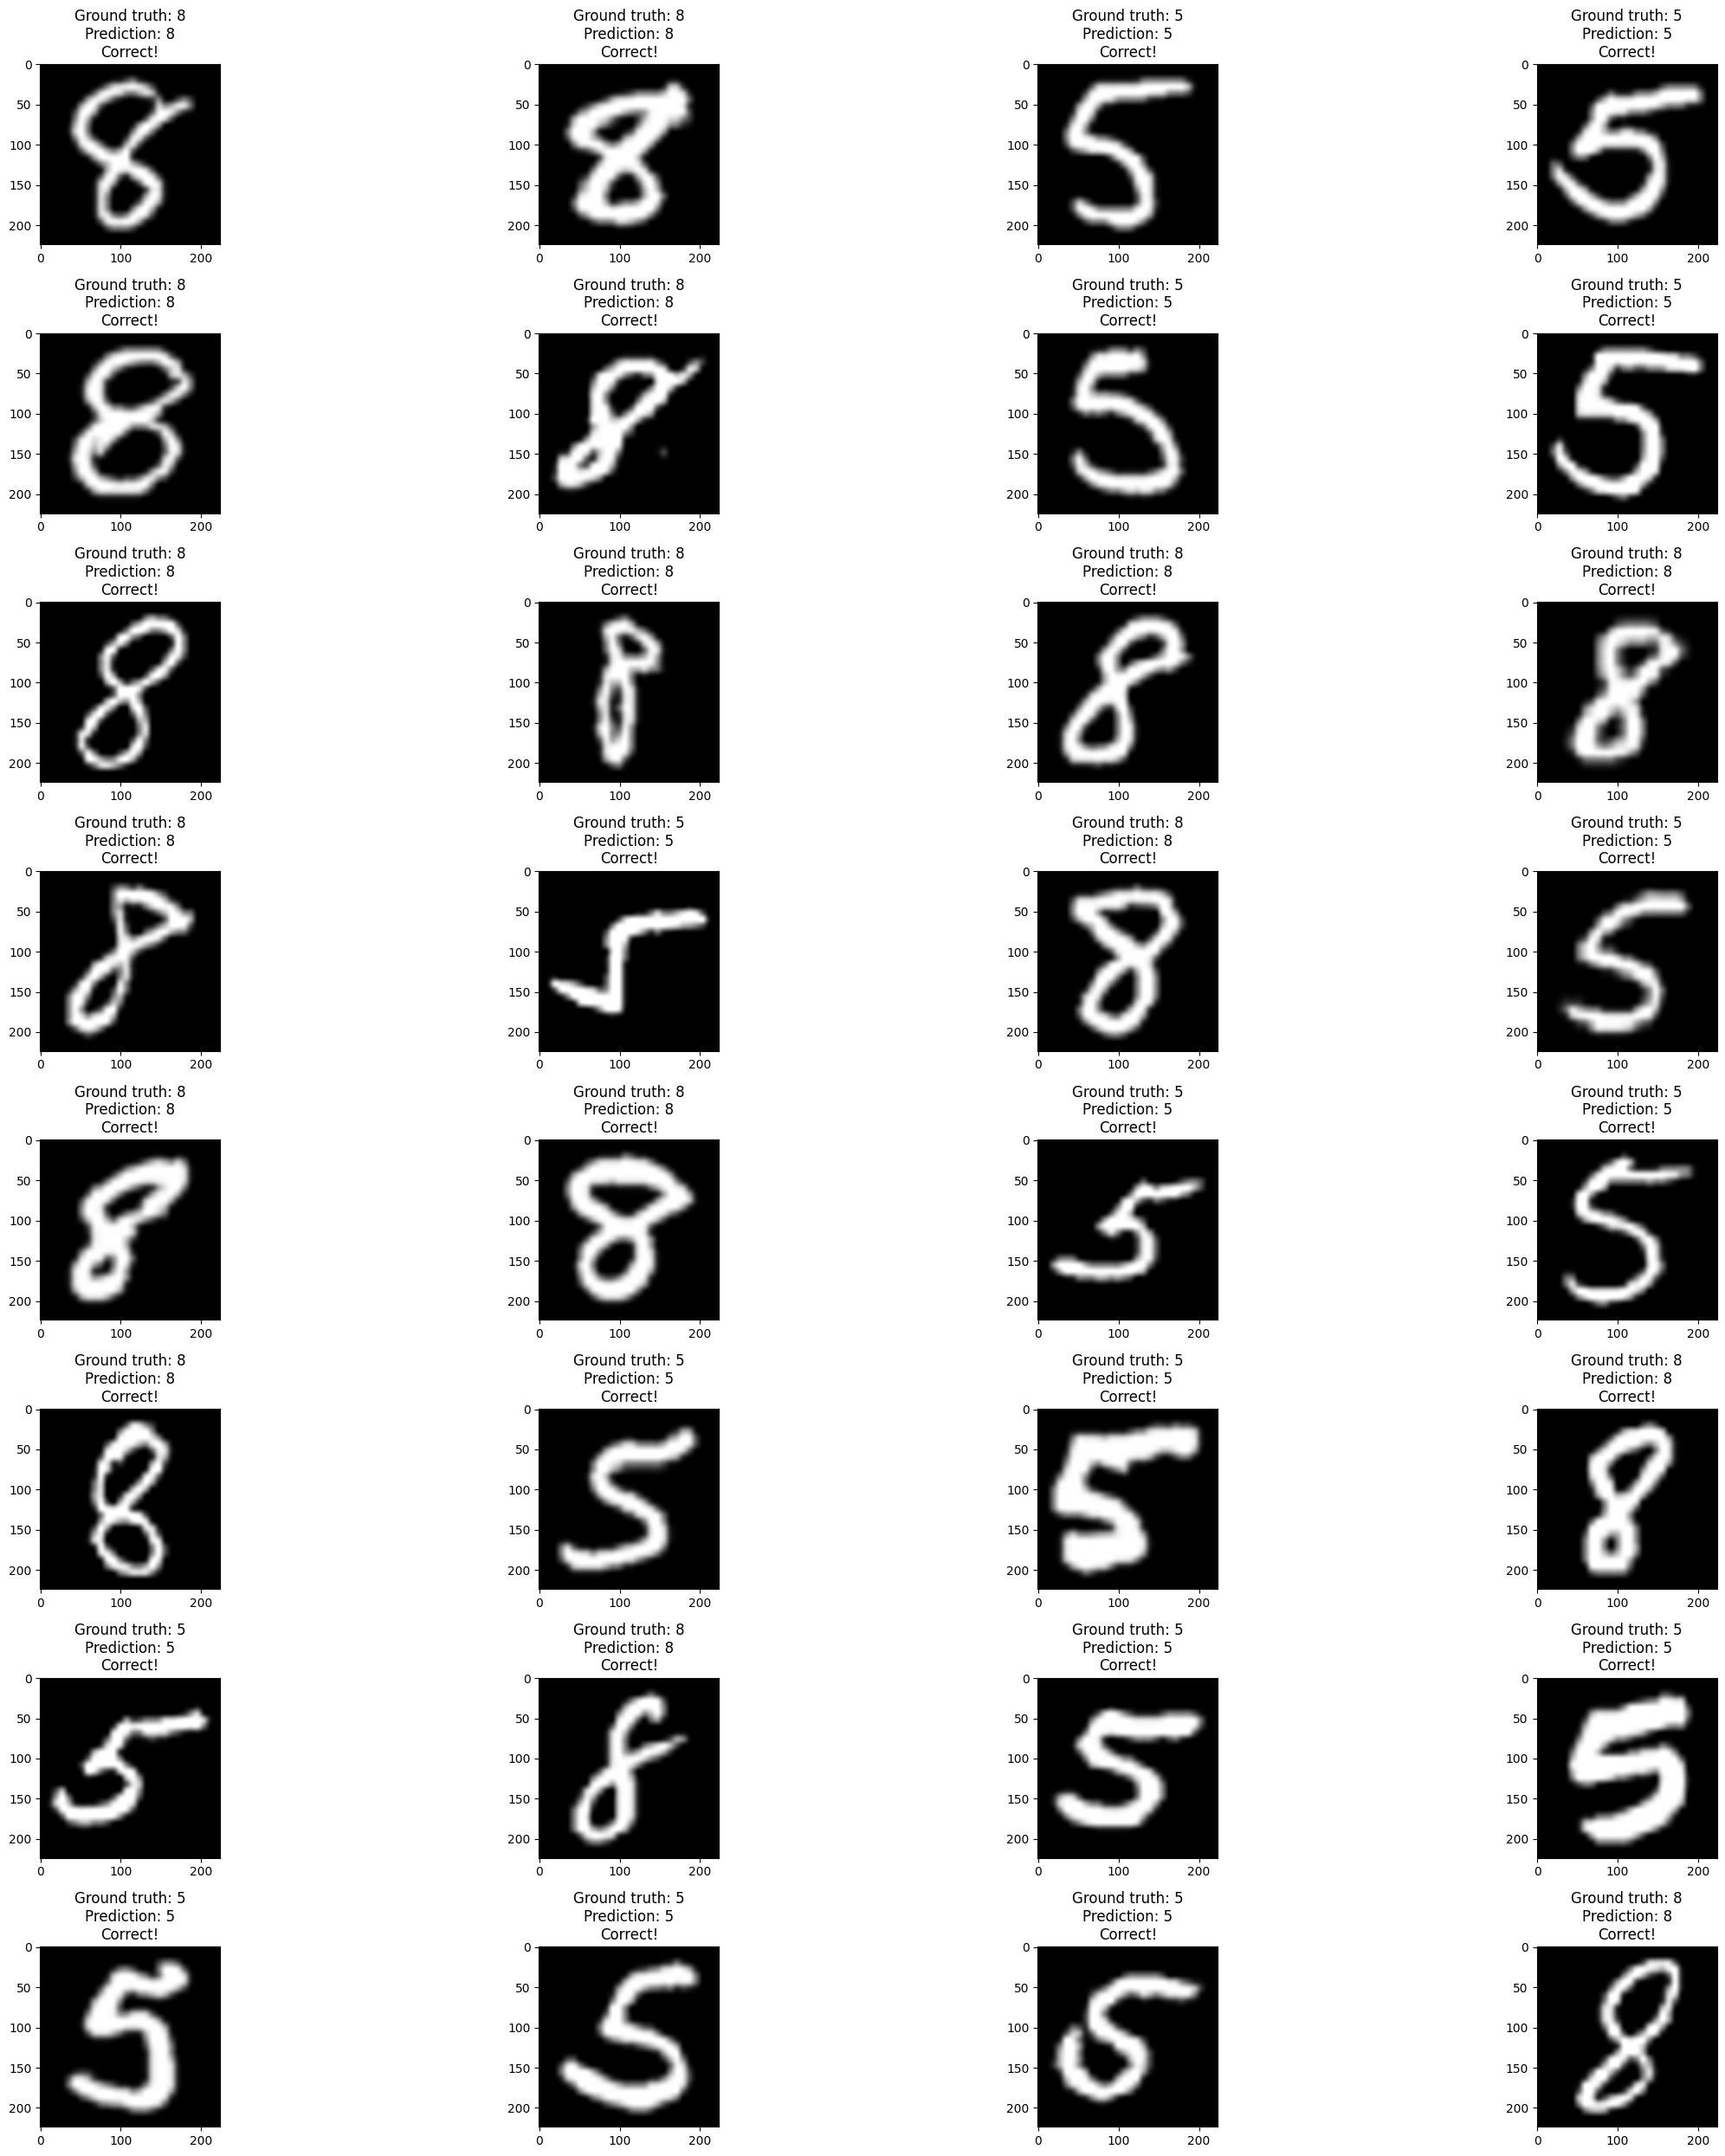

In [53]:
random_tests(train_loader, model, device, preprocess)

In [ ]:
random_tests(val_loader, model, device, preprocess)

In [ ]:
random_tests(test_loader, model, device, preprocess)

In [ ]:
random_tests(test_fool_loader, model, device, preprocess)